# Imports

In [ ]:
# Imports
import torch
import torchvision                                       
import torch.nn.functional as F                          
import torchvision.datasets as datasets                  
import torchvision.transforms as transforms              
from torch import optim                                  
from torch import nn                                     
from torch.utils.data import DataLoader                  
from tqdm import tqdm                                    
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [ ]:
# Make dirs
import os
os.makedirs('../data', exist_ok=True)

In [ ]:
# Hyperparameters
in_channels = 3
num_classes = 10
lr = 4e-3
batch_size = 128
num_epochs = 10
dim = 128
depth = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading dataset

In [ ]:
# Load Data
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(in_channels)], [0.5 for _ in range(in_channels)] # custom normalization can be applied here!
                            ),
    ]
                                )

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transforms)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transforms)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
def plot_images(dataset):
    plt.figure(figsize=(10, 10))
    for i in range(1, 101, 1): # 100 images
        plt.subplot(10, 10, i)
        plt.imshow(dataset.data[i])
        plt.axis('off')
    plt.show()

plot_images(dataset=trainset)

# ConvMixer Layer and the Whole Architecture
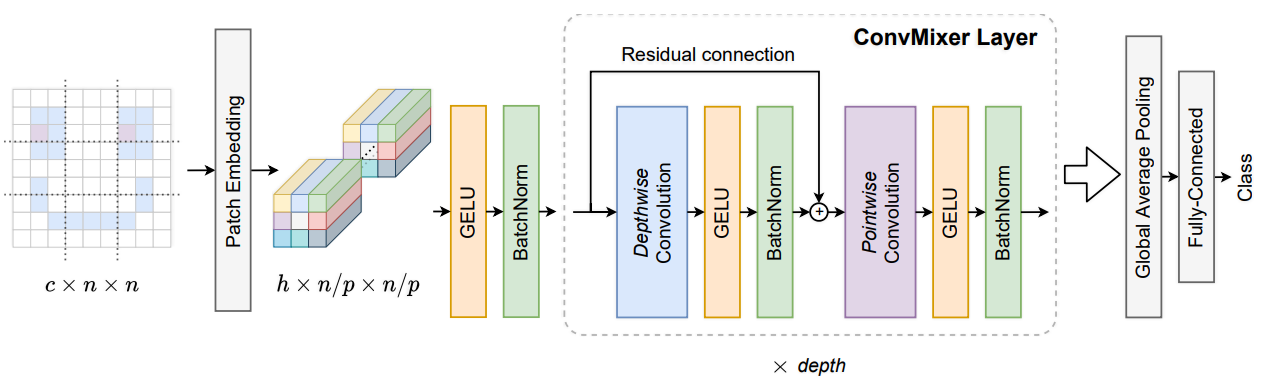


In [ ]:
# - ConvMixer
# https://github.com/locuslab/convmixer/tree/main

# Point-wise Conv
# https://www.analyticsvidhya.com/blog/2023/11/exploring-pointwise-convolution-in-cnns-replacing-fully-connected-layers/
# preserve spatial information in the feature maps

# Depth-wise Conv
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

class ConvMixerLayer(nn.Module):
    """ConvMixer layer: Depth-Wise Convolution with skip connection followed
       by applying a Point-Wise Convolution.
    """

    def __init__(self, dim, kernel_size):
        super().__init__()

        self.depth_wise_conv = nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )

        self.point_wise_conv = nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
                )

    def forward(self, x):
        return self.point_wise_conv(self.depth_wise_conv(x) + x)



class ConvMixer(nn.Module):
    """The whole ConvMixer architecture which consists of:
       1-Patch Embedding layer
       2-Several applications of ConvMixer layer according to the depth of the network.
       3-Global Average Pooling and flattening
       4-Passing feature to the classifier"""
    
    def __init__(self, in_channels, dim, depth, kernel_size, patch_size, num_classes):
        super().__init__()

        self.patch_embedding = nn.Sequential(nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size),
                                             nn.GELU(),
                                             nn.BatchNorm2d(dim)
                                            )

        self.conv_mixer_layers = nn.ModuleList([ConvMixerLayer(dim, kernel_size) for _ in range(depth)])

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(dim, num_classes)


    def forward(self, x):
        x = self.patch_embedding(x)              
        for mixer in self.conv_mixer_layers:     
            x = mixer(x)
            
        x = self.avgpool(x)                      
        x = self.flatten(x)                      

        return self.classifier(x)

# Training and Testing

In [ ]:
model = ConvMixer(in_channels, dim, depth, kernel_size=3, patch_size=4, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_index, (images, targets) in loop:
        images = images.to(device)
        targets = targets.to(device)
        logits = model(images)
        loss =  criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # progress bar information updating
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")


# get accuracy on training & test 
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            logits = model(x)
            _, predictions = logits.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples



print(f"Accuracy on training set: {get_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_accuracy(test_loader, model)*100:.2f}")
